# How does selecting a maximum frequency influence the AR surrogate analysis?

Geoffrey Brookshire

Do the results change if we only look below a set frequency?

In [1]:
# Import libraries and set up analyses
%matplotlib inline

import os
os.chdir('..')

In [2]:
import yaml
import copy
import itertools
import numpy as np
from scipy import signal, stats
import matplotlib.pyplot as plt
import analysis
import simulate_behavior as behav
import simulate_experiments as sim_exp
from analysis_methods import shuff_time, alternatives, utils
from generate_plots import remove_topright_axes
from stat_report_helpers import chi_square_report

# Suppress maximum likelihood estimation convergence warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

USE_CACHE = True  # Whether to use previously-saved simulations

behav_details = yaml.safe_load(open('behav_details.yaml'))

plt.ion()

plot_dir = 'plots/'
n_exp = 1000
behav_kwargs = {'noise_method': 'powerlaw',
                'exponent': 2}
osc_parameters = {'Rand walk': {'f_osc': 0, 'osc_amp': 0},
                  'Rand walk + osc': {'f_osc': 6, 'osc_amp': 0.4}}
method_names = {'LF2012': 'landau',
                'Robust est': 'mann_lees',
                'AR surr': 'ar'}

colors = {'Rand walk': 'red',
          'Rand walk + osc': 'dodgerblue'}

In [3]:
def cutoff_ar(freq_cutoff, **behav_kwargs):
    details = behav_details['landau']
    x_trial, t_trial = behav.simulate_behavior_trialwise(
        details, **behav_kwargs)
    t, x = utils.avg_repeated_timepoints(t_trial, x_trial)
    res = alternatives.ar_surr(x, details['fs'], details['k_perm'],
                               freq_cutoff=freq_cutoff)
    res['details'] = details
    res['t'] = t
    return res

In [4]:
freq_cutoffs = (15, 20, 25, 30)  # Only keep freqs below this value

examples = {}
prop_signif = {}
for osc_label, osc_params in osc_parameters.items():
    prop_signif[osc_label] = {}
    examples[osc_label] = {}
    
    for freq in freq_cutoffs:
        
        if freq == 15:  # Re-use main data for standard cutoff
            desc = ''
        else:
            desc = f'-freq_cutoff_{int(freq)}'

        def analysis_fnc(**behav_kwargs):
            """ Helper function
            """
            res = cutoff_ar(freq,
                            **behav_kwargs)
            return res

        if USE_CACHE or freq == 15:
            lit = analysis.load_simulation('ar',
                                           desc=desc,
                                           **behav_kwargs,
                                           **osc_params)

        else:

            lit = analysis.simulate_lit(analysis_fnc, n_exp,
                                        desc=desc,
                                        **behav_kwargs,
                                        **osc_params)
            analysis.save_simulation(lit,
                                     'ar',
                                     desc=desc,
                                     **behav_kwargs,
                                     **osc_params)
  
        p = analysis.prop_sig(lit)
        prop_signif[osc_label][freq] = p
        examples[osc_label][freq] = lit['result'][0]

loading: results/ar_exp_2.00_f_0.00_amp_0.00.npy
loading: results/ar_exp_2.00_f_0.00_amp_0.00-freq_cutoff_20.npy
loading: results/ar_exp_2.00_f_0.00_amp_0.00-freq_cutoff_25.npy
loading: results/ar_exp_2.00_f_0.00_amp_0.00-freq_cutoff_30.npy
loading: results/ar_exp_2.00_f_6.00_amp_0.40.npy
loading: results/ar_exp_2.00_f_6.00_amp_0.40-freq_cutoff_20.npy
loading: results/ar_exp_2.00_f_6.00_amp_0.40-freq_cutoff_25.npy
loading: results/ar_exp_2.00_f_6.00_amp_0.40-freq_cutoff_30.npy


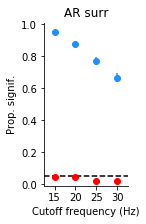

In [5]:
def prop_ci(p, n):
    """ 95% CI of a proportion
    """
    return 1.96 * np.sqrt((p * (1 - p)) / n)

plt.figure(figsize=(1.5, 3))
plt.axhline(y=0.05, color='k', linestyle='--')
for osc_label in osc_parameters.keys():
    psig = prop_signif[osc_label]
    labels = psig.keys()
    x_pos = np.arange(float(len(psig)))
    psig = np.array(list(psig.values()))
    plt.errorbar(x_pos, psig,
                 yerr=prop_ci(psig, n_exp),
                 fmt='o',
                 color=colors[osc_label],
                 label=osc_label)
plt.xticks(x_pos, labels)
plt.xlim([-0.5, len(psig) - 0.5])
plt.xlabel('Cutoff frequency (Hz)')
plt.ylim(-0.01, 1.01)
plt.ylabel('Prop. signif.')
plt.title('AR surr')
remove_topright_axes()
plt.savefig(f"{plot_dir}cutoff_freq.eps")

The analysis is less conservative and more powerful when we select only frequencies of interest (< 15 Hz).

Test for a difference between cutoff frequencies.

In [6]:
for osc_label in osc_parameters.keys():
    print('-', osc_label)
    psig = prop_signif[osc_label]
    labels = psig.keys()
    comp = (15, 30)
    # Make a contingency table
    msg = f' - {comp[0]} vs {comp[1]}: '
    p0 = psig[comp[0]]
    p1 = psig[comp[1]]
    tbl = [[p0 * n_exp, p1 * n_exp],
           [(1 - p0) * n_exp, (1 - p1) * n_exp]]
    tbl = np.array(tbl)
    msg += chi_square_report(tbl)
    print(msg)

- Rand walk
 - 15 vs 30: $\chi^2(1) = 8.5$, $p = 0.003$, $\phi_C = 0.07$ [0.03, 0.11]
- Rand walk + osc
 - 15 vs 30: $\chi^2(1) = 258.1$, $p = 4 \times 10^{-58}$, $\phi_C = 0.36$ [0.33, 0.39]


Test whether this method controls the rate of false positives for each cutoff frequency.

In [7]:
for freq in freq_cutoffs:
    prop = prop_signif['Rand walk'][freq]
    pval = stats.binom_test(prop * n_exp,
                            n_exp,
                            0.05,
                            alternative='greater')
    msg = f'- {freq}: {prop:.2f}, p = {pval:.1e}'
    if prop > 0.05 and pval < 0.05:
        msg += ' *'
    print(msg)

- 15: 0.04, p = 8.3e-01
- 20: 0.04, p = 8.6e-01
- 25: 0.02, p = 1.0e+00
- 30: 0.02, p = 1.0e+00
